In [ ]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
import torch.optim as optim

# Numerical model of linear elasticity model in firedrake and validate model

In [91]:
def forward_model(E, nu, strain_tensor):
    # Mesh refinement parameters
    nx, ny = 5, 1
    mesh = RectangleMesh(nx, ny, 1, 1)
    x, y = SpatialCoordinate(mesh)
    V = VectorFunctionSpace(mesh, 'CG', 1)
    # Test and trial function for the displacement field
    v, u_ = TestFunction(V), TrialFunction(V)
    u = Function(V, name="Displacement")

    # Lamé parameter
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # Constitutive equations
    def eps(v):
        return 0.5*(grad(v) + grad(v).T)
    def sigma(v):
        d = 2
        return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
    # Body force
    f = Constant((0.0, 0.0))
    
    # Convert strain tensor into displacement boundary conditions
    exx, eyy, exy = strain_tensor.dat.data[0,0,0], strain_tensor.dat.data[0,1,1], strain_tensor.dat.data[0,0,1]
    uLx = - exx/2 + exy * (y-.5)
    uLy = eyy * (y-.5) - exy/2
    uRx = exx/2 + exy * (y-.5)
    uRy = eyy * (y-.5) + exy/2
    
    uBx = exx * (x-.5) - exy/2
    uBy = - eyy/2 + exy * (x-.5)
    uTx = exx * (x-.5) + exy/2
    uTy = eyy/2 + exy * (x-.5)

    # Boundary conditions
    bcL = DirichletBC(V, [uLx, uLy], 1)
    bcR = DirichletBC(V, [uRx, uRy], 2)
    bcB = DirichletBC(V, [uBx, uBy], 3)
    bcT = DirichletBC(V, [uTx, uTy], 4)

    # Formal equation is div(sigma(u)) = f
    # Form
    a = inner(sigma(u_), eps(v)) * dx    
    L = inner(f, v) * dx
    # Solve PDE
    solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

    # Boundary stress
    sxx = assemble(.5*sigma(u)[0, 0] * ds(1) + .5*sigma(u)[0, 0] * ds(2))
    syy = assemble(.5*sigma(u)[1, 1] * ds(3) + .5*sigma(u)[1, 1] * ds(4))
    sxy_syx = assemble(.25*sigma(u)[0, 1] * ds(1) +
                       .25*sigma(u)[0, 1] * ds(2) +
                       .25*sigma(u)[1, 0] * ds(3) +
                       .25*sigma(u)[1, 0] * ds(4))
    # Enforce symmetry: Sxy = Syx
    stress_tensor = np.array([[sxx, sxy_syx],
                              [sxy_syx, syy]])
    stress_tensor = as_tensor(stress_tensor)
    return project(stress_tensor, V_tensor)


In [92]:
# check 
def check_forward(E,nu,strain_tensor):
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v), 0.1 is the trace of eps(v)
    s = lmbda*np.trace(strain_tensor)*np.eye(2) + 2*mu*strain_tensor
    return s


In [93]:

E = 30e3
nu = 0.3
strain_tensor = np.array([[0.01, 1],[1, 0.01]])
strain_fire = Constant([[0.01, 1], [1, 0.01]])
mesh = UnitSquareMesh(1,1)
V_tensor = TensorFunctionSpace(mesh, "CG", 1)
strain_fire = project(strain_fire, V_tensor)

stress_tensor = forward_model(E, nu, strain_fire)
stress_true = check_forward(E, nu, strain_tensor)


In [94]:
print('stress_tensor', stress_tensor.dat.data[0])
print('strain_tensor', strain_tensor)
print("stress_true",stress_true)

stress_tensor [[  576.92307692 23076.92307692]
 [23076.92307692   576.92307692]]
strain_tensor [[0.01 1.  ]
 [1.   0.01]]
stress_true [[  576.92307692 23076.92307692]
 [23076.92307692   576.92307692]]


In [101]:
## fire version
def get_dataset(ntrain, ntest):
    X, y = [], []

    for i in tqdm(range(ntrain + ntest)):
        # Randomly generate E and nu within given ranges
        E = np.random.uniform(20e3, 50e3)  # Young's modulus in Pa
        nu = np.random.uniform(0.1, 0.3)      # Poisson's ratio
        # E = 20e3
        # nu = 0.2

        # Generate diagonal elements
        a11 = np.random.uniform(0.0, 0.2)
        a22 = -a11 * nu
        mean_strain = 0
        std_dev_strain = 0.02 / 2.576 # 99% exy range from -0.05 to 0.05
        a12 = np.random.normal(mean_strain, std_dev_strain)
        # Construct the 2x2 matrix
        strain = np.array([[a11, a12], [a12, a22]])
        
        # strain = project(as_tensor(strain), V_tensor)
        # stress = forward_model(E, nu, strain)
        stress = check_forward(E, nu, strain)
        
        # Flatten and concatenate [E, nu] and strain
        input_data = np.hstack([E, nu, a11, a22, a12])
        
        X.append(input_data)
        y.append([stress[0,0], stress[1,1], stress[0,1]])
        # y.append([stress.dat.data[0,0,0], stress.dat.data[0,1,1], stress.dat.data[0,0,1]])
    # print(y)
    # Convert lists to numpy arrays
    X_train, X_test = np.array(X[:ntrain]), np.array(X[ntrain:])
    y_train, y_test = np.array(y[:ntrain]), np.array(y[ntrain:])
    
    np.save("../data/datasets/linear_elasticity/X_train.npy", X_train)
    np.save("../data/datasets/linear_elasticity/y_train.npy", y_train)
    np.save("../data/datasets/linear_elasticity/X_test.npy", X_test)
    np.save("../data/datasets/linear_elasticity/y_test.npy", y_test)

In [102]:
ntrain = 4000
ntest = 400
get_dataset(ntrain, ntest)

100%|██████████| 4400/4400 [00:00<00:00, 53370.21it/s]


# Train

In [103]:
# Loading
X_train = np.load("../data/datasets/linear_elasticity/X_train.npy", allow_pickle=True)
X_test = np.load("../data/datasets/linear_elasticity/X_test.npy", allow_pickle=True)
y_train = np.load("../data/datasets/linear_elasticity/y_train.npy", allow_pickle=True)
y_test = np.load("../data/datasets/linear_elasticity/y_test.npy", allow_pickle=True)

In [104]:
# Print some of the data
num_samples_to_display = 10

for i in range(num_samples_to_display):
    E, nu, a11, a22, a12 = X_train[i]
    stress_xx,stress_yy, stress_xy = y_train[i][0], y_train[i][1], y_train[i][2]
    stress = np.array([[stress_xx, stress_xy], [stress_xy, stress_yy]])
    print(f"Sample {i+1}:")
    print("-----------")
    print(f"E: {E:.2e}")
    print(f"nu: {nu:.2f}")
    print(f"Strain:\n[[{a11:.3f}, {a12:.3f}]\n [{a12:.3f}, {a22:.3f}]]")
    print(f"Stress:\n{stress}")
    print()

Sample 1:
-----------
E: 4.74e+04
nu: 0.22
Strain:
[[0.117, -0.006]
 [-0.006, -0.025]]
Stress:
[[5901.05134365 -216.29362748]
 [-216.29362748  376.0488241 ]]

Sample 2:
-----------
E: 3.78e+04
nu: 0.21
Strain:
[[0.057, 0.006]
 [0.006, -0.012]]
Stress:
[[2272.24108287  182.18680176]
 [ 182.18680176  133.8308045 ]]

Sample 3:
-----------
E: 4.34e+04
nu: 0.16
Strain:
[[0.137, 0.003]
 [0.003, -0.022]]
Stress:
[[6125.97243044  128.47443671]
 [ 128.47443671  188.91490457]]

Sample 4:
-----------
E: 4.46e+04
nu: 0.24
Strain:
[[0.097, 0.006]
 [0.006, -0.023]]
Stress:
[[4705.56128517  229.69820004]
 [ 229.69820004  373.66755442]]

Sample 5:
-----------
E: 3.99e+04
nu: 0.24
Strain:
[[0.072, 0.000]
 [0.000, -0.017]]
Stress:
[[3.12241258e+03 3.10127718e+00]
 [3.10127718e+00 2.47725045e+02]]

Sample 6:
-----------
E: 3.15e+04
nu: 0.28
Strain:
[[0.020, -0.002]
 [-0.002, -0.006]]
Stress:
[[722.24211665 -45.95069494]
 [-45.95069494  86.70702843]]

Sample 7:
-----------
E: 3.96e+04
nu: 0.17
Strain:
[[0

In [105]:
import torch
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
print('X_train',X_train)
print('y_train', y_train)
# Compute the mean and standard deviation for the training data
X_mean = torch.mean(X_train_tensor, dim=0)
X_std = torch.std(X_train_tensor, dim=0)
y_mean = torch.mean(y_train_tensor, dim=0)
y_std = torch.std(y_train_tensor, dim=0)
# Standardize the training data
X_train_standardized = (X_train_tensor - X_mean) / X_std
y_train_standardized = (y_train_tensor - y_mean) / y_std
# Standardize the test data using the training data's statistics
X_test_standardized = (X_test_tensor - X_mean) / X_std
y_test_standardized = (y_test_tensor - y_mean) / y_std
print('mean and std ', y_mean, y_std)
print('\n')
print('X_train', X_train_standardized)
print('y_train', y_train_standardized)

print('\n')
print('X_train_back', X_train_standardized * X_std + X_mean)
print('y_train_back', y_train_standardized * y_std + y_mean)

X_train [[ 4.73949030e+04  2.16633267e-01  1.16573770e-01 -2.52537567e-02
  -5.55228529e-03]
 [ 3.77581190e+04  2.09666455e-01  5.66344494e-02 -1.18743442e-02
   5.83676488e-03]
 [ 4.33691117e+04  1.58649526e-01  1.36895991e-01 -2.17184842e-02
   3.43232406e-03]
 ...
 [ 4.02728484e+04  2.09138979e-01  7.03440255e-02 -1.47116776e-02
   3.44131224e-03]
 [ 2.09820004e+04  1.18524611e-01  1.26980944e-01 -1.50503670e-02
   4.32158175e-03]
 [ 3.71746448e+04  2.58768563e-01  1.99503312e-02 -5.16251853e-03
   4.78289195e-03]]
y_train [[5901.05134365  376.0488241  -216.29362748]
 [2272.24108287  133.8308045   182.18680176]
 [6125.97243044  188.91490457  128.47443671]
 ...
 [3009.11852707  176.16425376  114.61994748]
 [2708.17338906   43.85917467   81.06699586]
 [ 823.41952206   81.77304633  141.25099289]]
mean and std  tensor([3.7232e+03, 2.3433e+02, 2.3948e+00]) tensor([2403.2856,  240.7847,  231.0837])


X_train tensor([[ 1.4480,  0.3016,  0.2829, -0.3870, -0.7255],
        [ 0.3349,  0.1808,

# Machine learning models

In [106]:
import torch.nn as nn
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        
        # Define your model architecture
        self.fc1 = nn.Linear(5, 8)  # Input size is 6
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 3)  # Output size is 4

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x


In [ ]:
class DeepMLP_model(nn.Module):
    def __init__(self):
        super(DeepMLP_model, self).__init__()
        
        self.fc1 = nn.Linear(5, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

    def predict(self, x):
        x = self.forward(x)
        return x


In [ ]:
import torch.nn as nn

class CNN1D_model(nn.Module):
    def __init__(self):
        super(CNN1D_model, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 16, 3)  # Assuming input is reshaped to (batch_size, 1, 5)
        self.fc1 = nn.Linear(3*16, 8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Reshape to (batch_size, 1, 5)
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        return self.forward(x)


In [ ]:
import torch.nn as nn
class RNN_model(nn.Module):
    def __init__(self):
        super(RNN_model, self).__init__()
        
        self.rnn = nn.RNN(input_size=1, hidden_size=8, batch_first=True)  # Assuming input is reshaped to (batch_size, 5, 1)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(-1))  # Reshape to (batch_size, 5, 1)
        x = self.fc(x[:, -1, :])  # Use the last RNN output
        return x
    
    def predict(self, x):
        return self.forward(x)


In [ ]:
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(-1))
        x = self.fc(x[:, -1, :])
        return x
    
    def predict(self, x):
        return self.forward(x)


# Cross validation and standardisation

In [107]:
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
import os

WEIGHT_DECAY = 0.001  # Regularization strength

def train_cross_validation(model, dataset, k_folds, epochs, batch_size, lr, criterion, device,save_folder):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    train_losses = []
    val_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        model_fold = model()
        model_fold.to(device)
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        
        # Training loop for each fold
        for epoch in tqdm(range(epochs)):
            model_fold.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            current_val_loss = 0.0
            model_fold.eval()
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model_fold(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            
            if epoch == epochs - 1:
                print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            # Save model if the validation loss has decreased
            best_val_loss = np.Inf
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                torch.save(model_fold.state_dict(), os.path.join(save_folder, f'MLP_model_linear.pt'))
    # Plotting after all folds
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Fold 1/2


100%|██████████| 400/400 [00:22<00:00, 17.67it/s]


Train Loss: 0.0034, Val Loss: 0.0040
Fold 2/2


100%|██████████| 400/400 [00:22<00:00, 17.45it/s]

Train Loss: 0.0028, Val Loss: 0.0028


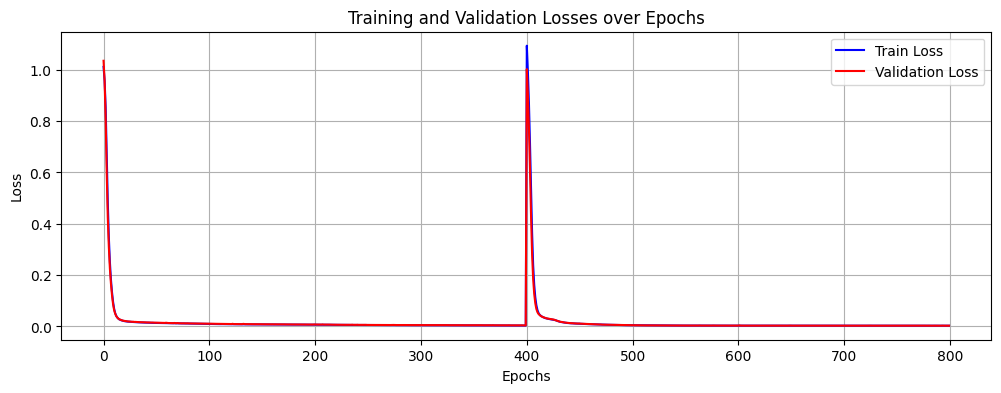

In [113]:
import torch
import torch.optim as optim

# Initialize the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, criterion and optimizer
model = MLP_model().to(device)
criterion = nn.MSELoss()
# Hyperparameters
EPOCHS = 400
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataset loading utilities
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
save_folder = '../saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_cross_validation(MLP_model, combined_dataset, k_folds=2, epochs=EPOCHS,batch_size=BATCH_SIZE, lr=LEARNING_RATE, criterion=criterion, device=device, save_folder=save_folder)


# Validation using MLP model

In [114]:
# Load the trained model
model_path = "../saved_models/MLP_model_linear.pt"
model = MLP_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()

MLP_model(
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)

In [115]:
strain_tensor = np.array([[0.05,0.01],[0.01, 0.05]])
E = 20e3
nu = 0.2

pred_input = torch.tensor([E, nu, strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]], dtype=torch.float32).unsqueeze(0)
pred_input = (pred_input - X_mean) / X_std
stress_pred = model.predict(pred_input)
stress_pred = stress_pred * y_std + y_mean
# convert to numpy array
stress_pred = stress_pred.detach().numpy()
# stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])
stress_pred = np.array([[stress_pred[0, 0], stress_pred[0, 2]], [stress_pred[0, 2], stress_pred[0, 1]]])

strain_fire = as_tensor(strain_tensor)
strain_fire = project(strain_fire, V_tensor)
# generate true stress
stress_ground_true = check_forward(E, nu, strain_tensor)
stress_true = forward_model(E, nu, strain_fire)

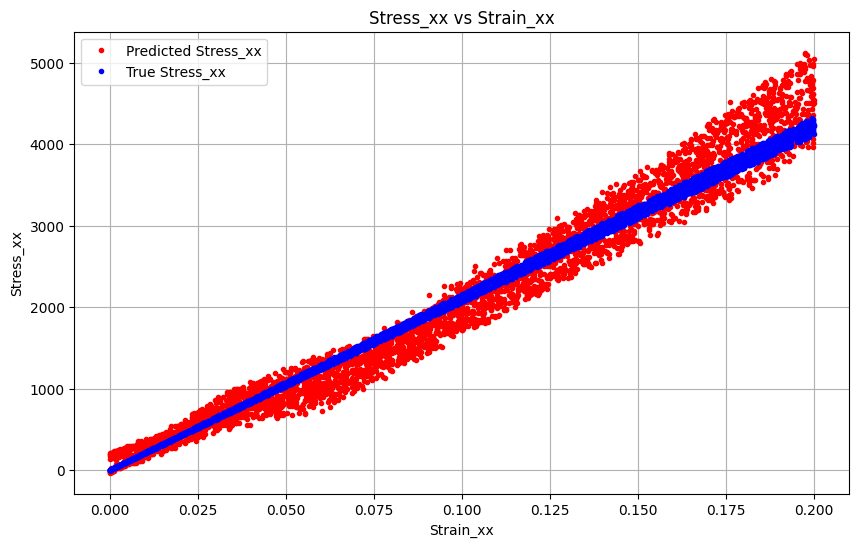

In [116]:
data = np.load('../data/datasets/linear_elasticity/X_train.npy')

exx = data[:,2]
eyy = data[:,3]
exy = data[:,4]

E = 20e3
nu = 0.2
strue = []
spred = []
for i in range(len(data)):
    strain_tensor = np.array([[data[i,2],data[i,4]],[data[i,4],data[i,3]]])
    stress_ground_true = check_forward(E, nu, strain_tensor)
    strue.append(stress_ground_true[0,0])

    pred_input = torch.tensor([E, nu, data[i,2],data[i,3],data[i,4]], dtype=torch.float32).unsqueeze(0)
    pred_input = (pred_input - X_mean) / X_std
    stress_pred = model.predict(pred_input)
    stress_pred = stress_pred * y_std + y_mean
    # convert to numpy array
    stress_pred = stress_pred.detach().numpy()
    # stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])
    stress_pred = np.array([[stress_pred[0, 0], stress_pred[0, 2]], [stress_pred[0, 2], stress_pred[0, 1]]])
    spred.append(stress_pred[0,0])

plt.figure(figsize=(10, 6))
plt.plot(exx, spred, 'r.', label='Predicted Stress_xx')
plt.plot(exx, strue, 'b.', label='True Stress_xx')
plt.xlabel('Strain_xx')
plt.ylabel('Stress_xx')
plt.title('Stress_xx vs Strain_xx')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print('stress prediction:', stress_pred)
print('stress true', stress_true.dat.data[0])
print('stress ground', stress_ground_true)

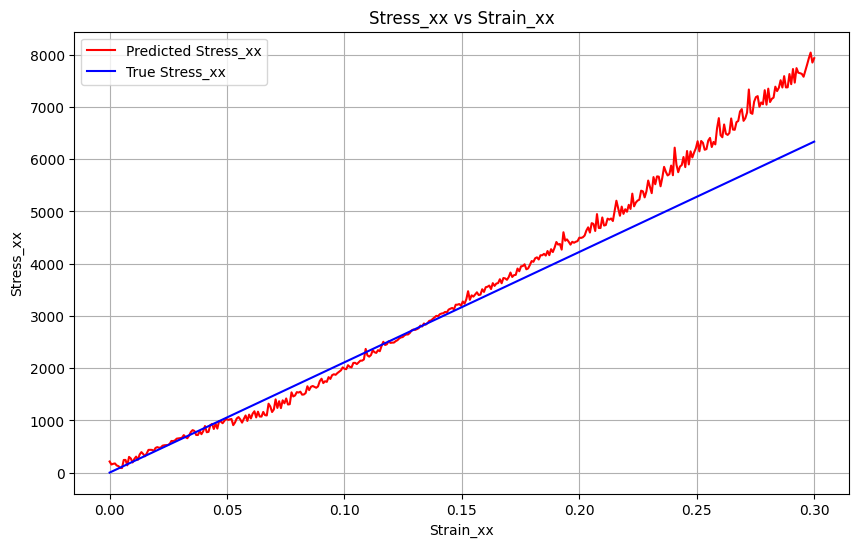

In [117]:
E = 20e3
nu = 0.2
c = []
strue = []
spred = []

# Generate diagonal elements
b = np.linspace(0, 0.3, 400)
for a in b:
    a11 = a
    c.append(a11)
    a22 = -a11 * nu
    mean_strain = 0
    std_dev_strain = 0.02 / 2.576 # 99% exy range from -0.05 to 0.05
    a12 = np.random.normal(mean_strain, std_dev_strain)
    # Construct the 2x2 matrix
    strain_tensor = np.array([[a11, a12], [a12, a22]])

    stress_ground_true = check_forward(E, nu, strain_tensor)
    strue.append(stress_ground_true[0,0])

    pred_input = torch.tensor([E, nu, a11, a22, a12], dtype=torch.float32).unsqueeze(0)
    pred_input = (pred_input - X_mean) / X_std
    stress_pred = model.predict(pred_input)
    stress_pred = stress_pred * y_std + y_mean
    # convert to numpy array
    stress_pred = stress_pred.detach().numpy()
    # stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])
    stress_pred = np.array([[stress_pred[0, 0], stress_pred[0, 2]], [stress_pred[0, 2], stress_pred[0, 1]]])
    spred.append(stress_pred[0,0])


plt.figure(figsize=(10, 6))
plt.plot(c, spred, 'r', label='Predicted Stress_xx')
plt.plot(c, strue, 'b', label='True Stress_xx')
plt.xlabel('Strain_xx')
plt.ylabel('Stress_xx')
plt.title('Stress_xx vs Strain_xx')
plt.legend()
plt.grid(True)
plt.show()



# Add physics loss

In [118]:
import os
# import parser
import torch.optim as optim
import torch.autograd as torch_ad

from sklearn.model_selection import KFold

from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

from firedrake import *
from firedrake_adjoint import *
from firedrake.ml.pytorch import torch_operator

from physics_driven_ml.dataset_processing import PDEDataset, BatchedElement
from physics_driven_ml.models import EncoderDecoder, CNN
from physics_driven_ml.utils import ModelConfig, get_logger
from physics_driven_ml.evaluation import evaluate


In [119]:
def solve_pde(input_data):
    #print(input_data)
    input_data = input_data * X_std + X_mean
    E = input_data[0][0]
    nu = input_data[0][1]
    exx, eyy, exy = input_data[0][2], input_data[0][3], input_data[0][4]
    strain_tensor = np.array([[exx, exy], [exy, eyy]])
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v), 0.1 is the trace of eps(v)
    s = lmbda*np.trace(strain_tensor)*np.eye(2) + 2*mu*strain_tensor
    output = torch.tensor([s[0,0], s[1,1], s[0,1]], dtype=torch.float32)
    stress = (output - y_mean) / y_std
    return stress

In [122]:
def train(model, config: ModelConfig,
        dataset,
        solver):
    """Train the model on a given dataset."""
    criterion = nn.MSELoss()
    
    best_error = 0.
    kfold = KFold(n_splits=config.K_fold, shuffle=True)
    train_losses = []
    val_losses = []
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{config.K_fold}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        # model = model()
        model.to(config.device)
        optimizer_fold = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.WEIGHT_DECAY)
        
        # training loop
        loss_phy_total = 0.0
        loss_ml_total = 0.0
        for epoch in tqdm(range(config.epochs)):
            model.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                # input=E,nu,strain[0,1,2], target=stress[0,1,2]
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model(inputs)                
                
                # calculate machine learning loss
                loss_ml = criterion(outputs, targets)
                loss_ml_total += loss_ml
                # calculate physics loss
                output_phy = solver(inputs)
                loss_phi = criterion(output_phy, targets)  
                loss_phy_total += loss_phi                
                
                # back propagation
                loss = 0.1 * loss_phi + loss_ml
                loss.backward()
                
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            # validation loop
            model.eval()
            current_val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            # print current losses
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            if epoch == config.epochs - 1:
                print(f"Epoch {epoch+1}/{config.epochs} | Train Loss: {current_train_loss/len(train_loader)} | Validation Loss: {current_val_loss/len(val_loader)}")

            # Save best-performing model
            if current_val_loss < best_error or epoch == 0:
                best_error = current_val_loss
                torch.save(model.state_dict(), os.path.join(save_folder, f'physics_mlp_model.pt'))
    # plot losses
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()    

    return model

Fold 1/3


100%|██████████| 250/250 [00:30<00:00,  8.20it/s]


Epoch 250/250 | Train Loss: 0.20622211075185434 | Validation Loss: 0.00230862581077457
Fold 2/3


100%|██████████| 250/250 [00:30<00:00,  8.28it/s]


Epoch 250/250 | Train Loss: 0.19138496271941974 | Validation Loss: 0.0018678175167777858
Fold 3/3


100%|██████████| 250/250 [00:30<00:00,  8.09it/s]

Epoch 250/250 | Train Loss: 0.18109201066924827 | Validation Loss: 0.0014340364432428032


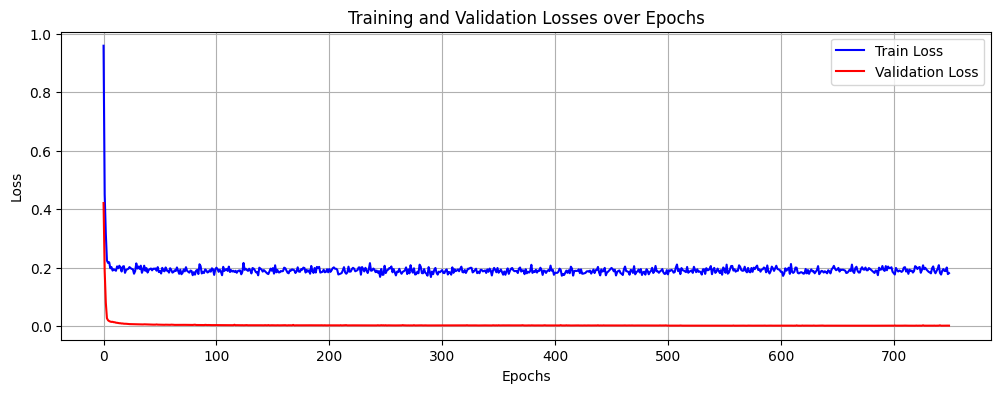

MLP_model(
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)

In [123]:
# args = parser.parse_args()
config = ModelConfig()
config.batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)
save_folder = '../saved_models'

config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.save_folder = '../saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_model = MLP_model()
train(train_model, config, combined_dataset, solver=solve_pde)

In [125]:
# Load the trained model
model_path = "../saved_models/physics_mlp_model.pt"
model = MLP_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()

MLP_model(
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)

In [126]:
strain_tensor = np.array([[0.05,0.01],[0.01, 0.05]])
E = 40e3
nu = 0.25

pred_input = torch.tensor([E, nu, strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]], dtype=torch.float32)
pred_input = (pred_input - X_mean) / X_std
stress_pred = model.predict(pred_input)
stress_pred = stress_pred * y_std + y_mean
# convert to numpy array
stress_pred = stress_pred.detach().numpy()
stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])

# generate true stress
stress_ground_true = check_forward(E, nu, strain_tensor)
stress_true = forward_model(E, nu, strain_fire)

In [127]:
print('stress prediction:', stress_pred)
print('stress ground', stress_ground_true)

stress prediction: [[-464.23315  317.00754]
 [ 317.00754 -188.40126]]
stress ground [[3200.  320.]
 [ 320. 3200.]]


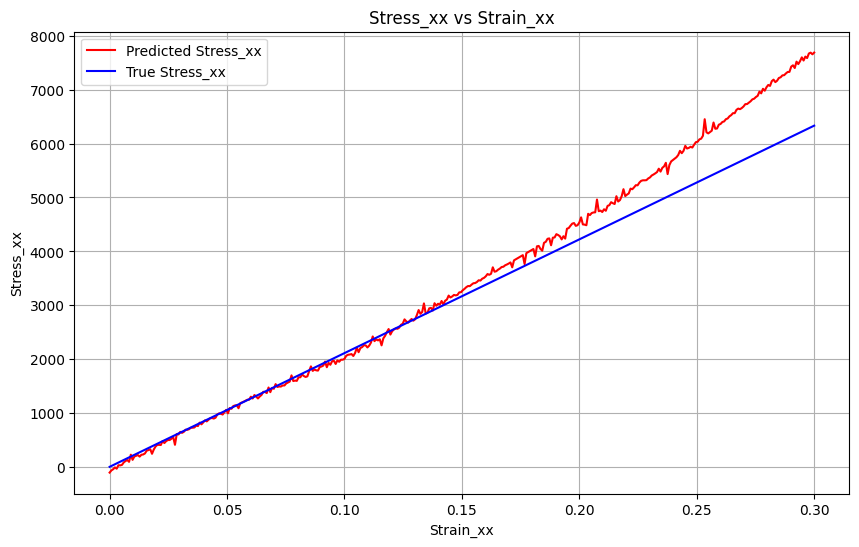

In [128]:
E = 20e3
nu = 0.2
c = []
strue = []
spred = []

# Generate diagonal elements
b = np.linspace(0, 0.3, 400)
for a in b:
    a11 = a
    c.append(a11)
    a22 = -a11 * nu
    mean_strain = 0
    std_dev_strain = 0.02 / 2.576 # 99% exy range from -0.05 to 0.05
    a12 = np.random.normal(mean_strain, std_dev_strain)
    # Construct the 2x2 matrix
    strain_tensor = np.array([[a11, a12], [a12, a22]])

    stress_ground_true = check_forward(E, nu, strain_tensor)
    strue.append(stress_ground_true[0,0])

    pred_input = torch.tensor([E, nu, a11, a22, a12], dtype=torch.float32).unsqueeze(0)
    pred_input = (pred_input - X_mean) / X_std
    stress_pred = model.predict(pred_input)
    stress_pred = stress_pred * y_std + y_mean
    # convert to numpy array
    stress_pred = stress_pred.detach().numpy()
    # stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])
    stress_pred = np.array([[stress_pred[0, 0], stress_pred[0, 2]], [stress_pred[0, 2], stress_pred[0, 1]]])
    spred.append(stress_pred[0,0])


plt.figure(figsize=(10, 6))
plt.plot(c, spred, 'r', label='Predicted Stress_xx')
plt.plot(c, strue, 'b', label='True Stress_xx')
plt.xlabel('Strain_xx')
plt.ylabel('Stress_xx')
plt.title('Stress_xx vs Strain_xx')
plt.legend()
plt.grid(True)
plt.show()

